In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
#import src.plot_vert as pv

/Users/masl3485/Desktop/NGIMS_homopause/env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
#ddf = pd.read_csv('../playground/k_Ls356-0_latN40-N70_data.csv')
#mdf = pd.read_csv('../playground/k_Ls356-0_latN40-N70_meta.csv')
ddf = pd.read_csv('../playground/k_Ls345-20_latN40-N70_data.csv')
mdf = pd.read_csv('../playground/k_Ls345-20_latN40-N70_meta.csv')
#ddf = pd.read_csv('../playground/k_Ls356-0_latN50-60_data.csv')
#mdf = pd.read_csv('../playground/k_Ls356-0_latN50-60_meta.csv')
#ddf = pd.read_csv('../playground/yLs0-20_latN50-N90_data.csv')
#mdf = pd.read_csv('../playground/yLs0-20_latN50-N90_meta.csv')

In [4]:
def color_obs(obsqual):
    if obsqual == 0:
        return 'k'
    elif obsqual == 1:
        return 'lightgreen'
    elif obsqual == 2:
        return 'lightblue'
    elif obsqual == 3:
        return 'darkblue'
    elif obsqual == 4:
        return 'lightcoral'
    elif obsqual == 5:
        return 'darkred'
    elif obsqual == 6:
        return 'r'
    elif obsqual == 7:
        return 'purple'
    elif obsqual == 10:
        return 'gray'
    elif obsqual == 11:
        return 'darkgreen'
    else:
        print 'Obs_qual not recognized'
        return 0

In [5]:
mdf['obs_col'] = mdf['Obs_qual'].apply(color_obs)

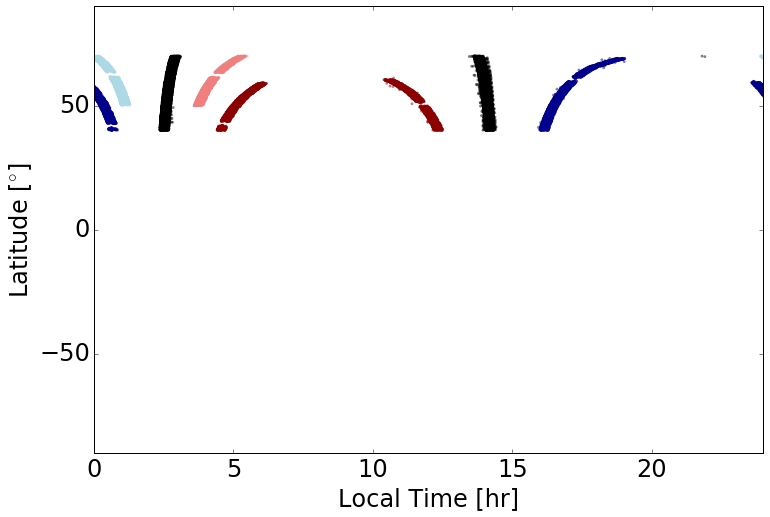

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(mdf['LTST']*24,mdf['Profile_lat'],color=list(mdf['obs_col']),s=8,alpha=0.5,lw=0)
plt.xlabel('Local Time [hr]',fontsize=24)
plt.ylabel(r'Latitude [$^{\circ}$]',fontsize=24)
plt.xlim(0,24)
plt.ylim(-90,90)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)
plt.show()

In [7]:
df = pd.merge(ddf,mdf,on=['Prof#'],suffixes=['_d','_m'])

In [8]:
term5cond = (df['Obs_qual'] == 5) & (df['LTST'] < 10/24.)
day5cond = (df['Obs_qual'] == 5) & (df['LTST'] > 10/24.)
term4cond = (df['Obs_qual'] == 4) & (df['LTST'] < 10/24.)
night0cond = (df['Obs_qual'] == 0) & (df['LTST'] > 10/24.)
day0cond = (df['Obs_qual'] == 0) & (df['LTST'] < 10/24.)
eve3cond = (df['Obs_qual'] == 3) & (df['LTST'] > 15/24.) & (df['LTST'] < 20/24.)

In [9]:
term5 = df[term5cond]
day5 = df[day5cond]
term4 = df[term4cond]
night0 = df[night0cond]
day0 = df[day0cond]
eve3 = df[eve3cond]

In [10]:
def bin_alt(df):
    altbins = np.arange(0,110,5)
    cut = pd.cut(df['Alt'],altbins)
    binned = df[['Alt','Pres','T','T_err']].groupby(cut).mean()
    binned['T_std'] = df[['T']].groupby(cut).std()
    binned['count'] = df[['T']].groupby(cut).count()
    binned = binned[binned['count'] > 30]
    return binned

In [11]:
term5b = bin_alt(term5)
day5b = bin_alt(day5)
term4b = bin_alt(term4)
night0b = bin_alt(night0)
day0b = bin_alt(day0)
eve3b = bin_alt(eve3)

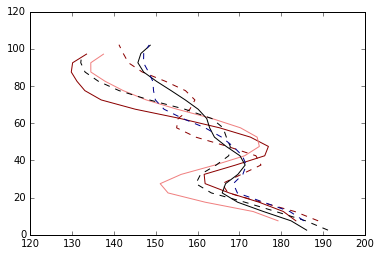

In [12]:
plt.figure()
plt.plot(term5b['T'],term5b['Alt'],c='darkred')
plt.plot(day5b['T'],day5b['Alt'],c='darkred',ls='--')
plt.plot(term4b['T'],term4b['Alt'],c='lightcoral')
plt.plot(night0b['T'],night0b['Alt'],c='k')
plt.plot(day0b['T'],day0b['Alt'],c='k',ls='--')
plt.plot(eve3b['T'],eve3b['Alt'],c='darkblue',ls='--')
plt.show()

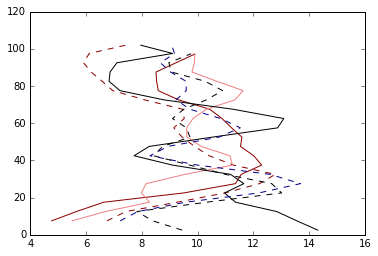

In [13]:
plt.figure()
plt.plot(term5b['T_std'],term5b['Alt'],c='darkred')
plt.plot(day5b['T_std'],day5b['Alt'],c='darkred',ls='--')
plt.plot(term4b['T_std'],term4b['Alt'],c='lightcoral')
plt.plot(night0b['T_std'],night0b['Alt'],c='k')
plt.plot(day0b['T_std'],day0b['Alt'],c='k',ls='--')
plt.plot(eve3b['T_std'],eve3b['Alt'],c='darkblue',ls='--')
plt.show()

In [31]:
lonbins = np.arange(-180,180,15)
altbins = np.arange(0,110,5)
lcut = pd.cut(night0['Profile_lon'],lonbins)
acut = pd.cut(night0['Alt'],altbins)
binm = night0.groupby([lcut,acut])['T'].mean()
bina = night0.groupby([lcut,acut])['Alt'].mean()
bins = night0.groupby([lcut,acut])['T'].std()
binc = night0.groupby([lcut,acut])['T'].count()

In [32]:
def convert_2d(df,cols):
    '''
    Convert Grouped/Binned DataFrame to 2d array to use for
    contour plot.
    
    Inputs
    ------
    df: DataFrame with at least 2 cols (x, y) (values are aggregated)
    cols: list, [x,y] names of columns 
    
    Outputs
    -------
    Xi, Yi, Z: np.meshgrid, 2d array of x, y, and z
    
    Example:
    binned_mean = ddf.groupby(['Lon_bin','Alt_bin'])['T'].mean()
    Xi, Yi, Z = convert_2d(binned_mean,['Lon_bin','Alt_bin'])
    '''
    dfreset = df.reset_index()
    df_pivot=dfreset.pivot(cols[0], cols[1])
    X=df_pivot.columns.levels[1].values
    Y=df_pivot.index.values
    Z=df_pivot.values
    Xi,Yi = np.meshgrid(X, Y)
    return Xi, Yi, Z

In [33]:
Xi_mean, Yi_mean, Z_mean = convert_2d(binm,['Profile_lon','Alt']) #temp 

ValueError: could not convert string to float: (-180, -165]

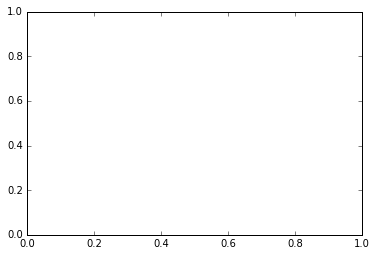

In [34]:
tfig, tax = plt.subplots()
ctc = tax.contourf(Yi_mean,Xi_mean,Z_mean)